# Data Challenge MDI343
## By Davide Garcia Civiero - MS IA

### Importing basic libraries

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import shap
import seaborn as sns
from xgboost import XGBClassifier
import pandas as pd
import random
from scipy.cluster import hierarchy

np.random.seed(seed=42)

### Basic functions

In [4]:
def extract_labels(txt_file):
    with open(txt_file) as file:
        lines = file.readlines()
    y = []
    for elem in lines:
        label = int(elem[0])
        y.append(label)
    y = np.array(y)
    return y

In [5]:
def criterion(y_pred, y_true):
    CM = confusion_matrix(y_true, y_pred)
    TN, TP = CM[0, 0], CM[1, 1]
    FP, FN = CM[0, 1], CM[1, 0]
    return FP/(FP + TN) + FN/(FN + TP)

In [6]:
X, y = np.load("train_data.npy"), extract_labels("train_labels.txt")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

### I - Data Preprocessing

Before to implement models or even visualize the data, it is important to preprocess the data so we are sure to work with good dataset.

#### Checking if the dataset is balanced

Text(0.5, 1.0, 'Histogram showing the label distribution')

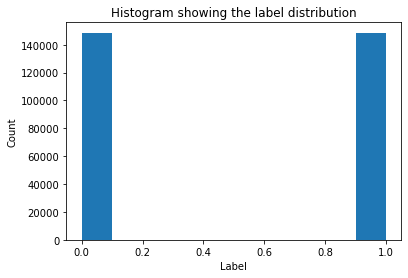

In [7]:
plt.figure(figsize=(6,4))
plt.hist(y)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Histogram showing the label distribution')

As we can see in the histogram, the dataset is balanced, we have the same amount of label '1' and label '2'.

#### Checking the data size and data type

In [10]:
print('Dataset dimensions :', X.shape)
print('Train set dimensions :', X_train.shape)
print('Valid set dimensions :', X_valid.shape)
print('X type :', X.dtype)
print('y type :', y.dtype)

Dataset dimensions : (297232, 96)
Train set dimensions : (267508, 96)
Valid set dimensions : (29724, 96)
X type : float64
y type : int32


#### Checking for missing or zero values

In [11]:
counter = 0
for el in X:
    if np.all(el == np.zeros(96)):
        counter += 1
print(There are {} zero values".format(counter))

0 zero values


In [12]:
print(X)

[[236.031      1.         0.       ...   2.503      0.         0.      ]
 [228.04       1.         0.       ...   2.245238   1.         0.      ]
 [158.31       1.         0.       ...   3.006712   1.         0.      ]
 ...
 [219.495      1.         0.       ...   1.779      0.         0.      ]
 [111.054      1.         0.       ...  -2.154      0.         0.      ]
 [221.947      1.         0.       ...   0.25       0.         0.      ]]


At first glance, the data seems to not to be centered and reduced. Before implementing the algorithms, we will Standardize the data with Scikit-Learn tools. The train et valid set will be standardized separatly, because they can have different distributions. We won't forget to standardize the X_test once the model will be implemented.

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)

In [15]:
X_train

array([[-1.84931897,  0.1328165 , -0.10108304, ...,  0.77885253,
        -0.29676524, -0.12698229],
       [ 0.37051513,  0.1328165 , -0.10108304, ...,  1.23034315,
        -0.29676524, -0.12698229],
       [ 1.36259011,  0.1328165 , -0.10108304, ...,  0.43472967,
        -0.29676524, -0.12698229],
       ...,
       [-1.06407085, -0.0291947 ,  0.1199204 , ..., -1.12795225,
        -0.29676524,  8.04431848],
       [ 0.69947177,  0.1328165 , -0.10108304, ...,  0.74587409,
        -0.29676524, -0.12698229],
       [ 0.46883318,  0.1328165 , -0.10108304, ...,  0.73237042,
        -0.29676524, -0.12698229]])

The variables are now centered and scaled.

### II - Exploratory Data Analysis - Data Visualization

The second step in this data challenge is to discover and understand the data. Thus, the exploratory data analysis will allow us to have a better understanding of the problem by analyzing and visualizying the data with multiple plots.

### Pairplot

The pairplot will give us an overview of the data distribution. The issue is that we have too many points and many features (96). Thus, to improve the plotting time, I will first resample the data with fewer points.

In [26]:
df = pd.DataFrame(X_train)
df['labels'] = y_train.tolist()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,labels
0,-1.849319,0.132817,-0.101083,-0.089215,0.008999,0.762955,-0.368513,-1.108319,-0.962649,-0.263286,...,0.601904,0.733877,-0.677186,0.282311,0.472850,-0.062024,0.778853,-0.296765,-0.126982,0
1,0.370515,0.132817,-0.101083,-0.089215,-0.050955,0.345719,-0.150457,-0.257065,-0.962649,-0.263286,...,-0.387224,0.475479,-0.455506,0.152339,0.404919,-0.062024,1.230343,-0.296765,-0.126982,0
2,1.362590,0.132817,-0.101083,-0.089215,-0.403091,0.920883,0.439680,1.601889,1.040236,-0.254735,...,0.420932,0.764970,1.451075,-0.339928,0.627342,-0.062024,0.434730,-0.296765,-0.126982,1
3,-0.521527,0.132817,-0.101083,-0.089215,0.236637,0.202256,-0.531190,-0.241575,-0.962649,-0.263286,...,0.671689,-0.378939,-0.478996,0.376052,0.296500,-0.062024,0.775221,-0.296765,-0.126982,1
4,0.383398,0.132817,-0.101083,-0.089215,-0.371428,0.653446,0.153438,0.478085,1.040236,-0.259011,...,0.284654,0.781642,0.631403,-0.678397,0.736292,-0.062024,-1.507876,3.391164,-0.126982,1


In [27]:
df1 = df.sample(frac=0.005)
df1.shape

(1338, 97)

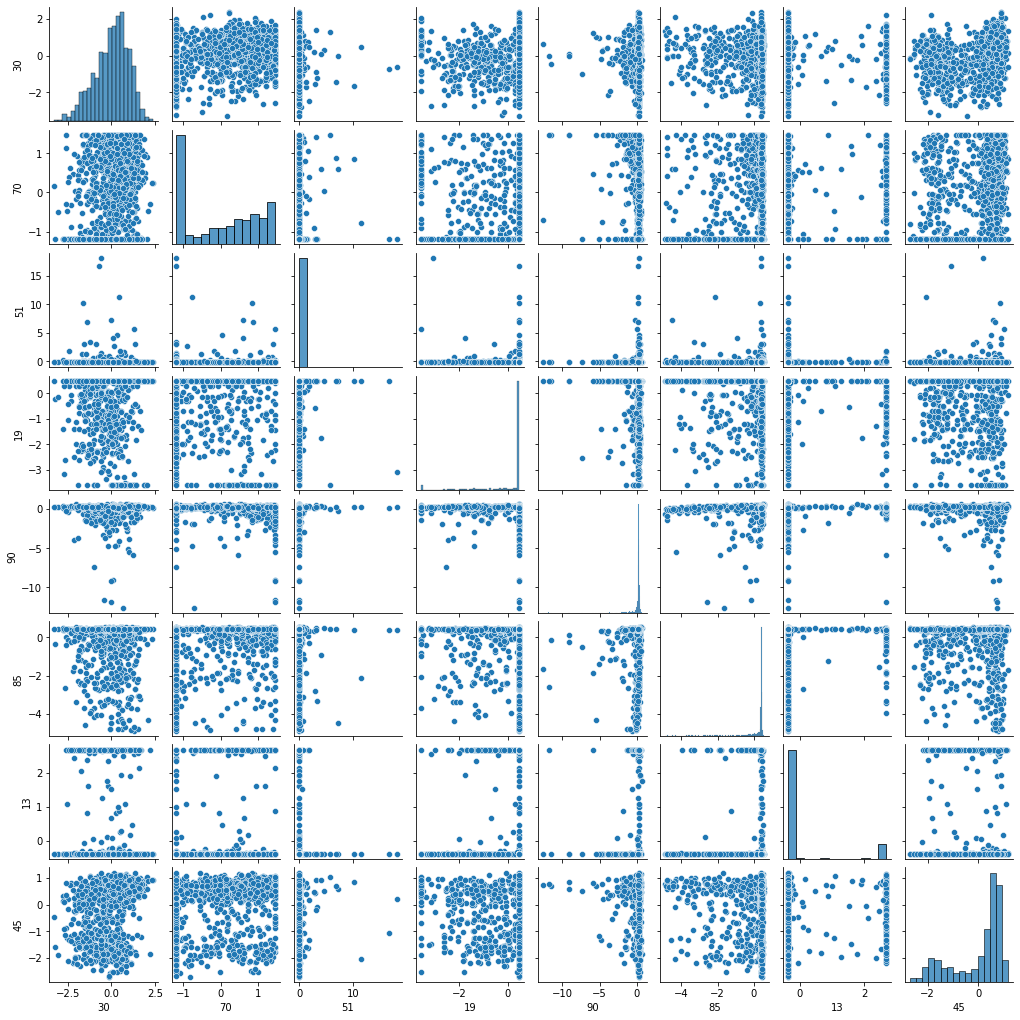

In [36]:
a = [random.randrange(1,96, 1) for i in range(8)]
sns.pairplot(df1[a], height=1.8)
plt.show()

8 random features have been plotted. We can see that not all the variables are centered and reduced. Thus it is important to standardize the data before feeding the data to a model to get better results (just as I did it in the preprocessing part). <br>
However, the plot is quite difficult to analyze because there can't seem to be correlations between the selected variables. In order to have a better overview, I will plot a correlation matrix to check the possible correlations between the features.

### Correlation matrix

In [30]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

The correlation matrix is a very powerful tool as we see the positive and negative correlations between all the features. However, as the dataset contains many features (96), the reading of this matrix is quite difficult. I will extract the most correlated features by selecting the ones with a correlation score prior of 0.9 (excluding the values in the diagonal of course).

In [31]:
features = list()
for col in corr.columns:
    for row in corr.index:
        if corr[row][col] >= 0.9 and corr[row][col] != 1:
            features.append((row, col))
features

[(32, 4),
 (56, 8),
 (45, 26),
 (4, 32),
 (26, 45),
 (80, 52),
 (8, 56),
 (65, 64),
 (64, 65),
 (93, 74),
 (52, 80),
 (74, 93)]

The most correlated features (>0.9) are : <br>
- 4 and 32
- 8 and 56
- 26 and 45
- 52 and 80
- 64 and 65
- 74 and 93

We observe that there are features in two different images that are correlated (for instance 8 and 56), but also correlated feautres inside of a same image (4 and 32, 26 and 45).

### Boxplots and violinplots

The boxplot gives informations on the median which is the line that divides the the box into 2 parts while the extreme line represent the maximum and minimum values . <br>
On the other hand, the violin plot allow to visualize the distribution of the variables. It is adapted in this case, where thye amount of data is huge.

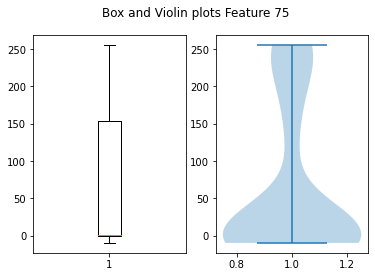

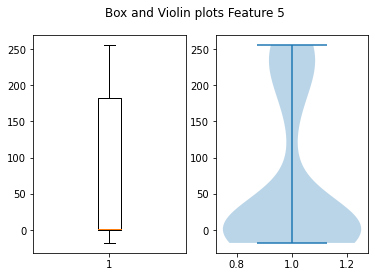

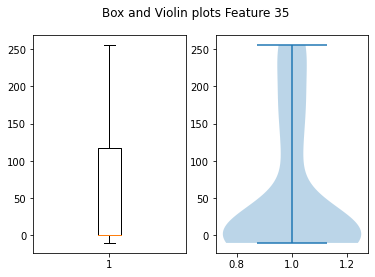

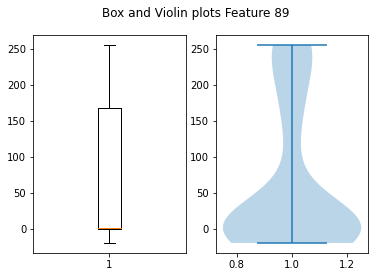

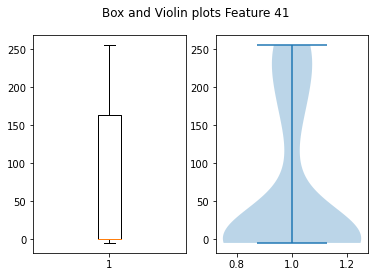

In [29]:
a = [random.randrange(1,96, 1) for i in range(5)]

for i in a:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Box and Violin plots Feature {}'.format(i))
    
    ax1.boxplot(X[i])
    ax2.violinplot(X[i])

Once again, the results are difficult to interpret. We don't have a clear intuition about the data as it is templates extracted from images. We can also see, thanks to the violin plots, that the distribution are concentrated on the extremes values in general.

### Scatter plots

This is a basic plot but it could give us some insights on the features.

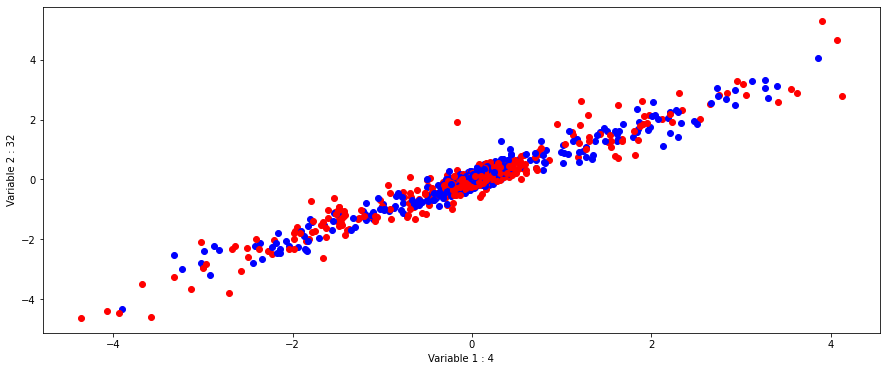

In [37]:
plt.figure(figsize=(15,6))
var1 = 4
var2 = 32
for i in range(1000):
    if df['labels'][i] == 0:
        plt.scatter(df[var1][i], df[var2][i], color='red')
    else:
        plt.scatter(df[var1][i], df[var2][i], color='blue')
plt.xlabel('Variable 1 : {}'.format(var1))
plt.ylabel('Variable 2 : {}'.format(var2))
plt.show()

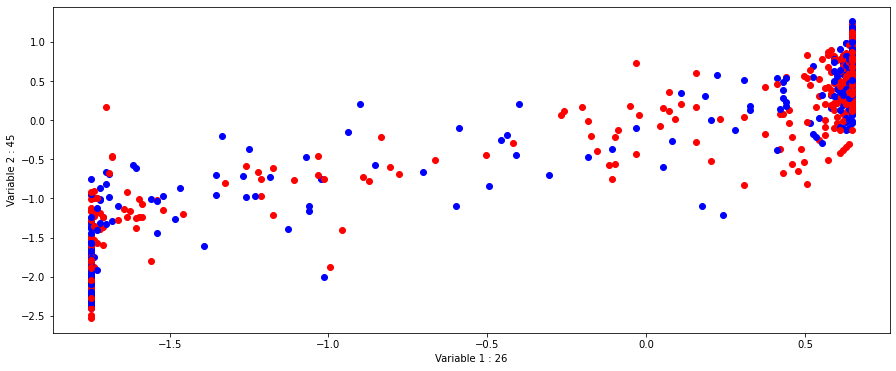

In [38]:
plt.figure(figsize=(15,6))
var1 = 26
var2 = 45
for i in range(1000):
    if df['labels'][i] == 0:
        plt.scatter(df[var1][i], df[var2][i], color='red')
    else:
        plt.scatter(df[var1][i], df[var2][i], color='blue')
plt.xlabel('Variable 1 : {}'.format(var1))
plt.ylabel('Variable 2 : {}'.format(var2))
plt.show()

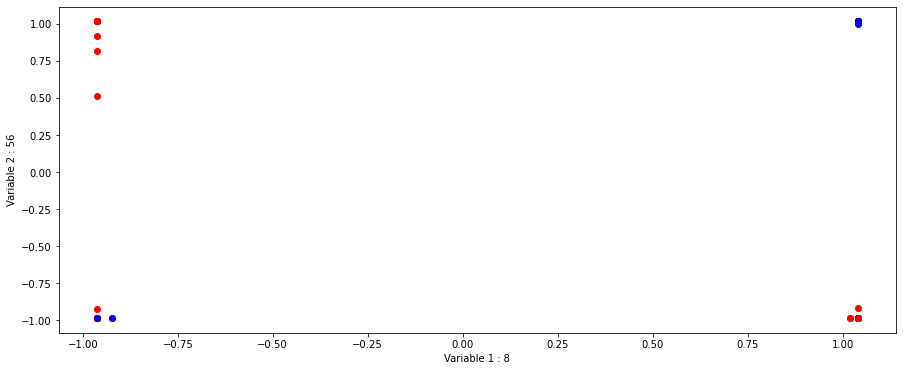

In [39]:
plt.figure(figsize=(15,6))
var1 = 8
var2 = 56
for i in range(1000):
    if df['labels'][i] == 0:
        plt.scatter(df[var1][i], df[var2][i], color='red')
    else:
        plt.scatter(df[var1][i], df[var2][i], color='blue')
plt.xlabel('Variable 1 : {}'.format(var1))
plt.ylabel('Variable 2 : {}'.format(var2))
plt.show()

The scatter plots shows confirm the positive correaltion between the features 4 and 32; the features 26 and 45. <br>
But the scatter plot with features 8 and 56 seems quite strange, there can't seems to be any correlation between them. Maybe because there is not enough data points.

### Dendograms

The last step of this data visualization is the dendograms. It shows the proximity between features by building a hierarchy graph with nodes connected by branches or edges. The dendograms will be computed with the Scipy package.

In [42]:
Z = hierarchy.linkage(X[0:48], 'ward')

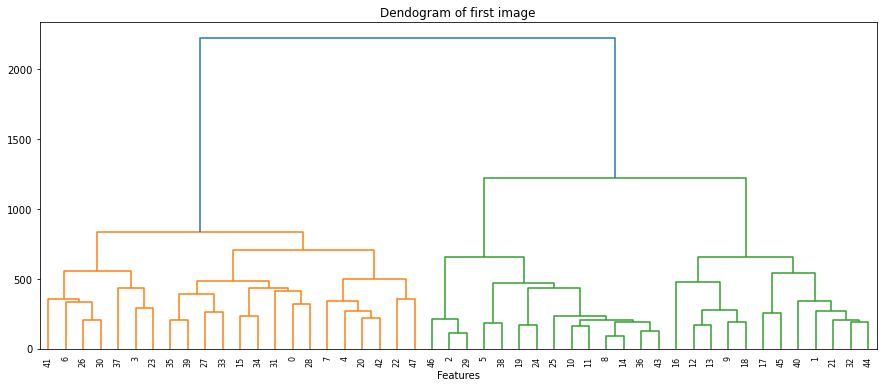

In [43]:
plt.figure(figsize=(15,6))
dn = hierarchy.dendrogram(Z)
plt.title('Dendogram')
plt.xlabel("Features")
plt.title('Dendogram of first image')
plt.show()

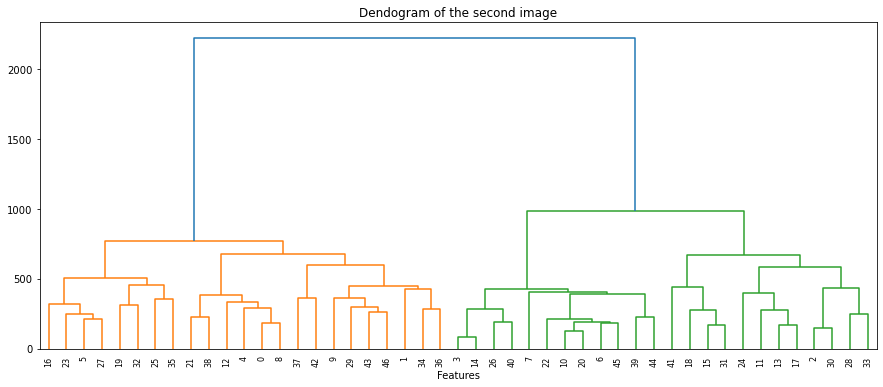

In [44]:
Z = hierarchy.linkage(X[49:96], 'ward')
plt.figure(figsize=(15,6))
dn = hierarchy.dendrogram(Z)
plt.title('Dendogram')
plt.xlabel("Features")
plt.title('Dendogram of the second image')
plt.show()

I decided to plot two dendograms : one for each of the two images represented by the data. The first thing we can observe, is that the two images don't have the same structure in the dendogram.

### II - First model : XGBoost

Here we are going to describe some of the models I have tested : the first is XGBoost. <br>
It is one, if not the most popular Machine Learning algorithm used in the industry because of its ease of use and efficiency. The Xgboost rely on the Ensemble Learning and particulalry on the Boosting method. <br>
At first, I tried to implement it with only the parameter 'n_estimator' set at 100 to see its performances.

In [45]:
xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:03:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
y_pred = xgb.predict(X_valid)
valid_score = criterion(y_pred, y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.4407148144017312


Confusion Matrix: 
 [[13337  1568]
 [ 4972  9847]]
Accuracy: 0.779975777149778
False Positive Rate: 0.10519959745051996
False Negative Rate: 0.3355152169512113
FPR + FNR = 0.4407148144017312
score =  0.5592851855982688


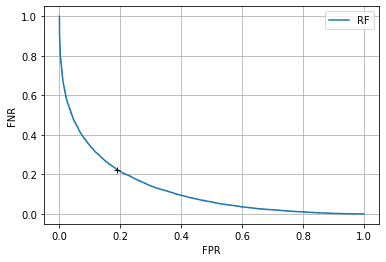

In [48]:
# to further inspect the performance:
CM = confusion_matrix(y_valid, y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))

print("score = ", 1 - (FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
y_prob = xgb.predict_proba(X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

The first result obtained is about 0.559 whichis quite small. In order to have better results with XGBoost and get the most of this algorithm, I tried to search the right hyperparameters with a random search.

### III - XGBoost with hyperparameter fine tuning (Random Search)

For this step, I run the following cell (commented) in a Google Colab Notebook. Thus, I could use a GPU to run it faster.

In [49]:
'''
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in range(40, 180, 20)]
max_depth = [2, 4, 6]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

# Param grid
param_grid = {'n_estimators': n_estimators,
             'max_depth': max_depth,
             'booster':['gbtree','gblinear'],
              'learning_rate': [0.1, 0.01], 
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap}

xgb = XGBClassifier()

xgb_opt = RandomizedSearchCV(estimator=xgb , param_distributions=param_grid , cv= 5,
                          verbose=2)
xgb_opt.fit(X_train, y_train)

params = xgb_opt.best_params_
'''

"\nfrom sklearn.model_selection import RandomizedSearchCV\n\nn_estimators = [int(x) for x in range(40, 180, 20)]\nmax_depth = [2, 4, 6]\nmin_samples_split = [2, 5]\nmin_samples_leaf = [1, 2]\nbootstrap = [True, False]\n\n# Param grid\nparam_grid = {'n_estimators': n_estimators,\n             'max_depth': max_depth,\n             'booster':['gbtree','gblinear'],\n              'learning_rate': [0.1, 0.01], \n             'min_samples_split': min_samples_split,\n             'min_samples_leaf': min_samples_leaf,\n             'bootstrap': bootstrap}\n\nxgb = XGBClassifier()\n\nxgb_opt = RandomizedSearchCV(estimator=xgb , param_distributions=param_grid , cv= 5,\n                          verbose=2)\nxgb_opt.fit(X_train, y_train)\n\nparams = xgb_opt.best_params_\n"

The best combination found was : 'bootstrap=False, max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=120' <br>
Now let's see its performances :

In [50]:
xgb_opt = XGBClassifier(bootstrap=False, max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=120)
xgb_opt.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:12:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "bootstrap", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:12:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=False,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, min_samples_leaf=2, min_samples_split=5,
              missing=nan, monotone_constraints='()', n_estimators=120,
              n_jobs=12, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, ...)

In [52]:
y_pred = xgb_opt.predict(X_valid)
valid_score = criterion(y_pred, y_valid)
print('FPR + FNR = {}'.format(valid_score))

FPR + FNR = 0.41212324341587186


Confusion Matrix: 
 [[12696  2209]
 [ 3911 10908]]
Accuracy: 0.7941057731126363
False Positive Rate: 0.14820530023482054
False Negative Rate: 0.26391794318105133
FPR + FNR = 0.41212324341587186
score =  0.5878767565841281


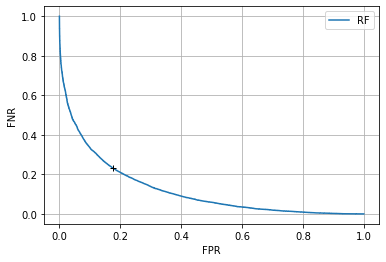

In [53]:
# to further inspect the performance:
CM = confusion_matrix(y_valid, y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))

print("score = ", 1 - (FP / (FP + TN) + FN / (FN + TP)))
plt.figure(figsize=(6,4))
plt.grid()
y_prob = xgb_opt.predict_proba(X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, y_prob, pos_label=1)
idx = np.argmin(fpr + (1-tpr))
plt.plot(fpr, 1-tpr, label='RF')
plt.plot(fpr[idx], (1-tpr)[idx], '+', color='k')
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.show()

The result with a random search for hyperparameters tuning is quite better. but it is still low. Another point of improvement could come from the feature selection.

### IV - XGBoost Feature selection : PCA

### V - XGBoost Feature selection : Shap value

### VI - Neural Networks